In [22]:
import logging
import os
import sys
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, Integer, String, TIMESTAMP, MetaData, ForeignKey
from sqlalchemy.sql import select

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CREDENTIALS_PATH = os.path.abspath("/home/guzzo/Software/credentials/")
sys.path.append(CREDENTIALS_PATH)
import twitch_psql

def render_passwd(code):
    passwd = ''.join([x[0] for x in code.split(" ")])
    return passwd

In [3]:
psql_password = render_passwd(twitch_psql.PSQL_PASSWD)
psql_login = twitch_psql.USERNAME
psql_host = twitch_psql.PSQL_HOST
psql_db = 'twitchbot'

In [4]:
engine = create_engine('postgresql+psycopg2://{}:{}@{}/{}'.format(
    psql_login, psql_password, psql_host, psql_db
), echo = True)

In [5]:
metadata = MetaData(engine)

In [6]:
# users = Table('users', metadata, autoload=True)  # , autoload_with=engine)
metadata.reflect(bind=engine)

2018-01-26 21:28:31,295 INFO sqlalchemy.engine.base.Engine select version()
2018-01-26 21:28:31,299 INFO sqlalchemy.engine.base.Engine {}
2018-01-26 21:28:31,344 INFO sqlalchemy.engine.base.Engine select current_schema()
2018-01-26 21:28:31,345 INFO sqlalchemy.engine.base.Engine {}
2018-01-26 21:28:31,391 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-01-26 21:28:31,392 INFO sqlalchemy.engine.base.Engine {}
2018-01-26 21:28:31,413 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-01-26 21:28:31,414 INFO sqlalchemy.engine.base.Engine {}
2018-01-26 21:28:31,456 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2018-01-26 21:28:31,457 INFO sqlalchemy.engine.base.Engine {}
2018-01-26 21:28:31,499 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind = 'r'
2018-01-26 21:

2018-01-26 21:28:31,813 INFO sqlalchemy.engine.base.Engine 
            SELECT a.attname,
              pg_catalog.format_type(a.atttypid, a.atttypmod),
              (SELECT pg_catalog.pg_get_expr(d.adbin, d.adrelid)
                FROM pg_catalog.pg_attrdef d
               WHERE d.adrelid = a.attrelid AND d.adnum = a.attnum
               AND a.atthasdef)
              AS DEFAULT,
              a.attnotnull, a.attnum, a.attrelid as table_oid,
              pgd.description as comment
            FROM pg_catalog.pg_attribute a
            LEFT JOIN pg_catalog.pg_description pgd ON (
                pgd.objoid = a.attrelid AND pgd.objsubid = a.attnum)
            WHERE a.attrelid = %(table_oid)s
            AND a.attnum > 0 AND NOT a.attisdropped
            ORDER BY a.attnum
        
2018-01-26 21:28:31,813 INFO sqlalchemy.engine.base.Engine {'table_oid': 24904}
2018-01-26 21:28:31,842 INFO sqlalchemy.engine.base.Engine 
            SELECT t.typname as "name",
               pg_catal

In [7]:
metadata.tables.keys()

dict_keys(['users', 'views_follows'])

In [8]:
users = metadata.tables['users']
views_follows = metadata.tables['views_follows']

In [9]:
with engine.begin() as conn:
    result = conn.execute(select([users.c.id, users.c.view_count]))
ddd = {}
for row in result:
    ddd[row['id']] = row['view_count']
len(ddd)
# len(set(x['id'] for x in result))
# len({x[1]: x[0] for x in result})
# len({x[users.c.view_count]: x[users.c.id] for x in result})
# next(result)
#from pprint import pprint
# pprint(users)
# pprint([x for x in views_follows.columns])
# lll = list(x for x in result.fetchall())

2018-01-26 21:28:37,943 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-01-26 21:28:37,945 INFO sqlalchemy.engine.base.Engine SELECT users.id, users.view_count 
FROM users
2018-01-26 21:28:37,945 INFO sqlalchemy.engine.base.Engine {}
2018-01-26 21:28:38,863 INFO sqlalchemy.engine.base.Engine COMMIT


71367

In [10]:
from itertools import islice
from pprint import pprint
with engine.begin() as conn:
    result = conn.execute(
        select([users.c.id, users.c.view_count]).order_by(users.c.view_count.desc()).limit(10)
    )
#     pprint([x for x in islice(result, 10)])
#     pprint([x for x in result])
    top_users = list(map(lambda x: x[0], result.fetchall()))

2018-01-26 21:29:05,768 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-01-26 21:29:05,771 INFO sqlalchemy.engine.base.Engine SELECT users.id, users.view_count 
FROM users ORDER BY users.view_count DESC 
 LIMIT %(param_1)s
2018-01-26 21:29:05,771 INFO sqlalchemy.engine.base.Engine {'param_1': 10}
2018-01-26 21:29:05,841 INFO sqlalchemy.engine.base.Engine COMMIT


In [11]:
top_users

['36029255',
 '28633177',
 '29578325',
 '88086517',
 '31239503',
 '24991333',
 '23161357',
 '30080751',
 '30080840',
 '26490481']

In [12]:
import json
import requests
from requests_oauthlib import OAuth2Session
from oauthlib.oauth2 import BackendApplicationClient
import time
from datetime import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
with open("/home/guzzo/Software/credentials/twitch_app.json") as f:
    tcrets = json.load(f)
    client_id = tcrets['client_id']
    client_secret = tcrets['client_secret']
    redirect_uri =  tcrets['redirect_uri']

In [14]:
# Load token
with open("/home/guzzo/Software/credentials/twitch_token.json") as f:
    token = json.load(f)

In [15]:
# (datetime.fromtimestamp(token['expires_at']) - datetime.now()).days
from datetime import timedelta
timedelta(seconds=token['expires_in']).days

59

In [16]:
oauth = OAuth2Session(
    client_id=client_id,
    token=token,
)

In [17]:
base_url = "https://api.twitch.tv/helix/"
# base_url_v5 = "https://api.twitch.tv/kraken/"
streams_url = base_url+"streams/"
headers = {"Authorization": "Bearer {} https://api.twitch.tv/helix/".format(token['access_token'])}
users_url = "https://api.twitch.tv/helix/users"

In [39]:
params = {
    "id": top_users
}
response_users = oauth.get(users_url, headers=headers, params=params)
response_users.json()['data'][:1]

[{'broadcaster_type': 'partner',
  'description': 'Welcome to the Riot Games Channel, home of LCS, LCK and LPL. For more information, schedules and stats, head to lolesports.com',
  'display_name': 'Riot Games',
  'id': '36029255',
  'login': 'riotgames',
  'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/fe43f2841cf6f962-channel_offline_image-1920x1080.jpeg',
  'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/riotgames-profile_image-4be3ad99629ac9ba-300x300.jpeg',
  'type': '',
  'view_count': 942299050}]

In [32]:
view_count = {x['id']: x['view_count'] for x in response_users.json()['data']}

view_count

{'23161357': 221284044,
 '24991333': 253995396,
 '26490481': 197298173,
 '28633177': 369693921,
 '29578325': 342167362,
 '30080751': 204219616,
 '30080840': 198153107,
 '31239503': 267488560,
 '36029255': 942252168,
 '88086517': 320039664}

In [26]:
follows_url = "https://api.twitch.tv/helix/users/follows"

In [34]:
users_dict = {}
for _uid in top_users:
#     _uid = 59189673
    params = {
    #     "to_id": 17337557,
        "to_id": _uid,
        "first": 1,
    }
    r_foll = oauth.get(follows_url, headers=headers, params=params)
    r_foll_json = r_foll.json()
    print(r_foll_json)
    users_dict[_uid] = r_foll_json['total']
    time.sleep(1)

{'total': 2688414, 'data': [{'from_id': '124521282', 'to_id': '36029255', 'followed_at': '2018-01-26T18:37:40Z'}], 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjoiMTUxNjk5MTg2MDM0NzU4MjAwMCJ9'}}
{'total': 452149, 'data': [{'from_id': '98604578', 'to_id': '28633177', 'followed_at': '2018-01-26T18:22:21Z'}], 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjoiMTUxNjk5MDk0MTcyOTA0NzAwMCJ9'}}
{'total': 558802, 'data': [{'from_id': '193064317', 'to_id': '29578325', 'followed_at': '2018-01-26T17:23:51Z'}], 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjoiMTUxNjk4NzQzMTM0NTAxMTAwMCJ9'}}
{'total': 82825, 'data': [{'from_id': '183495863', 'to_id': '88086517', 'followed_at': '2018-01-26T17:57:42Z'}], 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjoiMTUxNjk4OTQ2Mjc1MDI2NDAwMCJ9'}}
{'total': 2285806, 'data': [{'from_id': '188337166', 'to_id': '31239503', 'followed_at': '2018-01-26T18:37:27Z'}], 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjoiMTUxNjk5MTg0NzAxNDMzNzAwMCJ9'}}
{'total': 2132103, 'data': [{'from_id': 

In [35]:
users_dict

{'23161357': 1979095,
 '24991333': 2132103,
 '26490481': 2708664,
 '28633177': 452149,
 '29578325': 558802,
 '30080751': 1411371,
 '30080840': 883748,
 '31239503': 2285806,
 '36029255': 2688414,
 '88086517': 82825}

In [37]:
view_count

{'23161357': 221284044,
 '24991333': 253995396,
 '26490481': 197298173,
 '28633177': 369693921,
 '29578325': 342167362,
 '30080751': 204219616,
 '30080840': 198153107,
 '31239503': 267488560,
 '36029255': 942252168,
 '88086517': 320039664}

In [38]:
for k in view_count.keys():
    print(view_count[k], users_dict[k])

942252168 2688414
369693921 452149
342167362 558802
320039664 82825
267488560 2285806
253995396 2132103
221284044 1979095
204219616 1411371
198153107 883748
197298173 2708664


In [12]:
import pandas as pd

In [57]:
df_users = pd.read_sql(users.select().order_by(users.c.view_count.desc()).limit(2000), engine)

2018-01-26 23:57:31,642 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2018-01-26 23:57:31,643 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT users.id, users.login, users.display_name, users.type, users.broadcaster_type, users.description, users.profile_image_url, users.offline_image_url, users.view_count, users.last_check \nFROM users ORDER BY users.view_count DESC \n LIMIT %(param_1)s'}
2018-01-26 23:57:31,708 INFO sqlalchemy.engine.base.Engine SELECT users.id, users.login, users.display_name, users.type, users.broadcaster_type, users.description, users.profile_image_url, users.offline_image_url, users.view_count, users.last_check 
FROM users ORDER BY users.view_count DESC 
 LIMIT %(param_1)s
2018-01-26 23:57:31,709 INFO sqlalchemy.engine.base.Engine {'param_1': 2000}


In [58]:
df_users.head()

id             login      display_name type broadcaster_type  \
0  36029255         riotgames        Riot Games               partner   
1  28633177       starladder1       Starladder1               partner   
2  29578325   beyondthesummit   BeyondTheSummit               partner   
3  88086517  shadbasemurdertv  ShadbaseMurderTV               partner   
4  25473490         pgl_clean         pgl_clean               partner   

                                         description  \
0  Welcome to the Riot Games Channel, home of LCS...   
1                                 www.starladder.com   
2  Beyond The Summit is a broadcasting studio and...   
3  I dare do all that may become a man; Who dares...   
4                                                      

                                   profile_image_url  \
0  https://static-cdn.jtvnw.net/jtv_user_pictures...   
1  https://static-cdn.jtvnw.net/jtv_user_pictures...   
2  https://static-cdn.jtvnw.net/jtv_user_pictures...   
3  https://static-cdn.jtvnw.net/jtv_user_pictures...   
4  https://static-cdn.jtvnw.net/jtv_user_pictures...   

                                   offline_image_url  view_count  \
0  https://static-cdn.jtvnw.net/jtv_user_pictures...   942072197   
1  https://static-cdn.jtvnw.net/jtv_user_pictures...   369693302   
2  https://static-cdn.jtvnw.net/jtv_user_pictures...   342167209   
3  https://static-cdn.jtvnw.net/jtv_user_pictures...   319910721   
4                                                      277287758   

                  last_check  
0 2018-01-26 13:46:27.201375  
1 2018-01-26 14:08:59.259466  
2 2018-01-26 13:46:27.201375  
3 2018-01-26 13:46:27.201375  
4 2018-01-26 22:13:01.311509

In [61]:
df_users.set_index('id', inplace=True)

In [62]:
# df_users[df_users['id']=='36029255']

In [15]:
# with engine.begin() as conn:
#     result = conn.execute(views_follows.select())
# ddd = {}
# for row in result:
#     print(row)
df = pd.read_sql(views_follows.select(), engine)

2018-01-26 21:34:38,028 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2018-01-26 21:34:38,029 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT views_follows.query_tstamp, views_follows.user_id, views_follows.view_count, views_follows.follows_count \nFROM views_follows'}
2018-01-26 21:34:38,092 INFO sqlalchemy.engine.base.Engine SELECT views_follows.query_tstamp, views_follows.user_id, views_follows.view_count, views_follows.follows_count 
FROM views_follows
2018-01-26 21:34:38,093 INFO sqlalchemy.engine.base.Engine {}


In [39]:
df.set_index('query_tstamp', inplace=True)

In [40]:
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2018-01-26 20:15:15.925705 to 2018-01-26 20:33:01.718414
Data columns (total 3 columns):
user_id          100 non-null object
view_count       100 non-null int64
follows_count    100 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.1+ KB


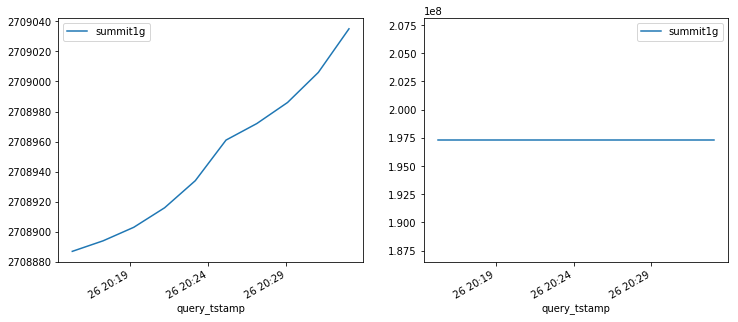

In [65]:
# df.set_index('query_tstamp').plot(by='user_id')
fig, axes = plt.subplots(1,2, figsize=(12,5))
for _uid in df.user_id.unique()[-1:]:
    df.loc[df.user_id == _uid, 'follows_count'].plot(label=df_users.loc[_uid]['display_name'], ax=axes[0])
    df.loc[df.user_id == _uid, 'view_count'].plot(label=df_users.loc[_uid]['display_name'], ax=axes[1])
# [ax.set_yscale('log') for ax in axes]\
[ax.legend() for ax in axes]